# Please don't forget to upvote this notebook
Thank you

![](https://images11.domashnyochag.ru/upload/img_cache/157/1572dda59b3e8ac590349e412550149f_ce_1200x627x0x0_fitted_1200x630.jpg)

# Analysis of SIIM-ISIC Melanoma Classification Metadata and Images

Skin cancer is common cancer type and despite beign mostly non malignant, due to high case numbers it's pretty serious diasease and can lead serious cases if not detected, treated in time. It's usually diagnosed by eye for primarily and followed by further clinical analysis if needed. Even though the rares outcome is called melanoma it's the most deadly one, so early detection is pretty important. For this task using computer aided diagnosis might be helpful for primarily steps and early detections. Better detection might save thousands of lives.



Many thanks :
https://www.kaggle.com/datafan07/eda-modelling-of-the-external-data-inc-ensemble
https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble
https://www.kaggle.com/andradaolteanu/siim-melanoma-competition-eda-augmentations
    
    
<iframe width="560" height="315" src="https://www.youtube.com/embed/epMqgs7g4cc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Loading the Data

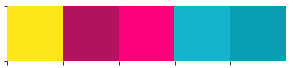

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

import seaborn as sns
import plotly.express as px

import pydicom # for DICOM images
from skimage.transform import resize

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import os
import random
import re
import math
import time
from IPython.display import display_html
import missingno as msno 
import gc
import cv2
import matplotlib.image as mpimg

# Set Color Palettes for the notebook (https://color.adobe.com/)
colors_nude = ['#FFE61A','#B2125F','#FF007B','#14B4CC','#099CB3']
sns.palplot(sns.color_palette(colors_nude))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)


import warnings

warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs


seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [2]:
# loading datasets

train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
sample = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')

In [3]:
train.sample(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
8231,ISIC_2566319,IP_9258690,male,35.0,upper extremity,nevus,benign,0
21862,ISIC_6617618,IP_5350484,male,30.0,lower extremity,unknown,benign,0
3058,ISIC_1018102,IP_3723085,female,40.0,torso,unknown,benign,0
7474,ISIC_2334999,IP_7779275,female,45.0,upper extremity,unknown,benign,0
3470,ISIC_1151651,IP_9754730,female,55.0,head/neck,nevus,benign,0


In [4]:
test.sample(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
3444,ISIC_3217925,IP_2245284,female,35.0,torso
354,ISIC_0445097,IP_4987053,female,45.0,lower extremity
4091,ISIC_3807024,IP_1792727,male,50.0,lower extremity
2388,ISIC_2257432,IP_8996365,female,55.0,torso
6924,ISIC_6288943,IP_3329371,male,50.0,head/neck


# CSV Files , Test + Train

In [5]:
# loading datasets

train = pd.read_csv('../input/melanomaextendedtabular/external_upsampled_tabular.csv')
test = pd.read_csv('../input/melanomaextendedtabular/test_tabular.csv')
sample = pd.read_csv('../input/melanomaextendedtabular/sample_submission.csv')

In [6]:
# checking column names

print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations and Test data {test.shape[1]} features, {test.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\nTest features are:\n{test.columns.tolist()}'
)

Train data has 7 features, 58916 observations and Test data 6 features, 10982 observations.
Train features are:
['image_name', 'sex', 'age_approx', 'anatom_site_general_challenge', 'target', 'width', 'height']
Test features are:
['image_name', 'sex', 'age_approx', 'anatom_site_general_challenge', 'width', 'height']


In [7]:
# renaming column names for easier use

train.columns = [
    'img_name','sex', 'age', 'location', 'target','width','height'
]

test.columns = ['img_name','sex', 'age', 'location','width', 'height']

Text(0.5, 1.0, 'Test Data Missing Values')

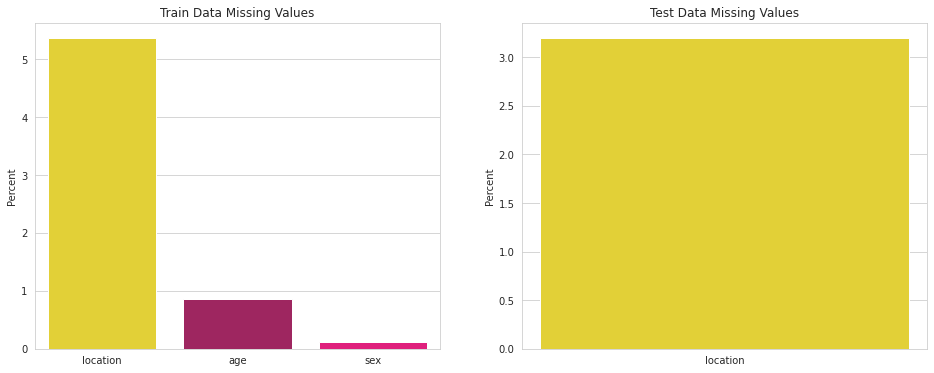

In [8]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train)
missing_test = missing_percentage(test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette=colors_nude,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette=colors_nude,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

In [9]:
# Directory
directory = '../input/siim-isic-melanoma-classification'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


In [10]:
df1_styler = train_df.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data')
df2_styler = test_df.head().style.set_table_attributes("style='display:inline'").set_caption('Head Test Data')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Head Train Data dcm_name ID sex age anatomy diagnosis benign_malignant target 
 
 0 
 ISIC_2637011 
 IP_7279968 
 male 
 45.000000 
 head/neck 
 unknown 
 benign 
 0 
 
 
 1 
 ISIC_0015719 
 IP_3075186 
 female 
 45.000000 
 upper extremity 
 unknown 
 benign 
 0 
 
 
 2 
 ISIC_0052212 
 IP_2842074 
 female 
 50.000000 
 lower extremity 
 nevus 
 benign 
 0 
 
 
 3 
 ISIC_0068279 
 IP_6890425 
 female 
 45.000000 
 head/neck 
 unknown 
 benign 
 0 
 
 
 4 
 ISIC_0074268 
 IP_8723313 
 female 
 55.000000 
 upper extremity 
 unknown 
 benign 
 0 
 
 Head Test Data dcm_name ID sex age anatomy 
 
 0 
 ISIC_0052060 
 IP_3579794 
 male 
 70.000000 
 nan 
 
 
 1 
 ISIC_0052349 
 IP_7782715 
 male 
 40.000000 
 lower extremity 
 
 
 2 
 ISIC_0058510 
 IP_7960270 
 female 
 55.000000 
 torso 
 
 
 3 
 ISIC_0073313 
 IP_6375035 
 female 
 50.000000 
 torso 
 
 
 4 
 ISIC_0073502 
 IP_0589375 
 female 
 45.000000 
 lower extremity

# Check missing values

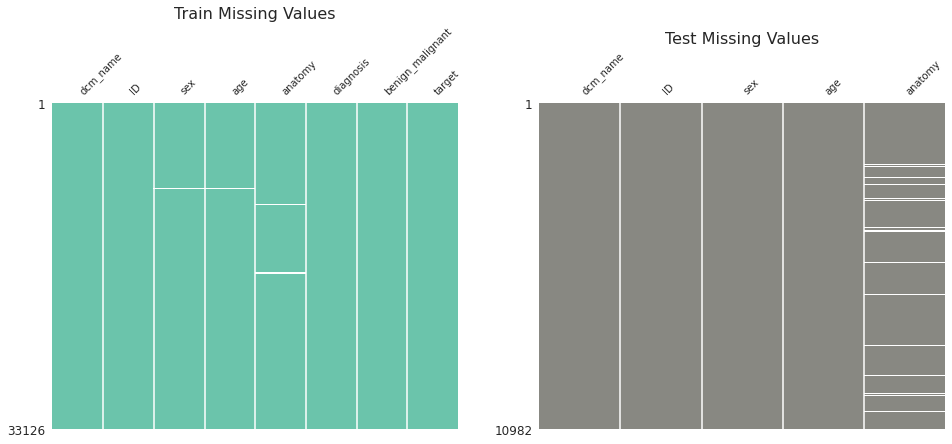

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax = ax1, color=(107/255, 196/255, 171/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(136/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values', fontsize = 16)
ax2.set_title('Test Missing Values', fontsize = 16);

# Differences in distribution by age and gender

In [12]:
#labels
lab = train["sex"].value_counts().keys().tolist()

#values
val = train["sex"].value_counts().values.tolist()

trace1 = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Gender Distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )


lab2 = train["age"].value_counts().keys().tolist()

#values
val2 = train["age"].value_counts().values.tolist()

trace2 = go.Pie(labels = lab2 ,
               values = val2 ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Age Distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace1,trace2]
fig  = go.Figure(data = data,layout = layout)
py.iplot(fig)


# Sunburstt

In [13]:
# Filling missing  values with 'unknown' and '-1' tags:

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)
    
train['sex'].fillna('unknown', inplace=True)

train['age'].fillna(-1, inplace=True)

In [14]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train,
                  path=['target', 'sex', 'location'],
                  color='sex',
                  color_discrete_sequence=colors_nude,
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig.show()

# Train: ANATOMY Variable

In [15]:
# Impute for anatomy
train_df['anatomy'].fillna('torso', inplace = True) 

# Test: ANATOMY Variable

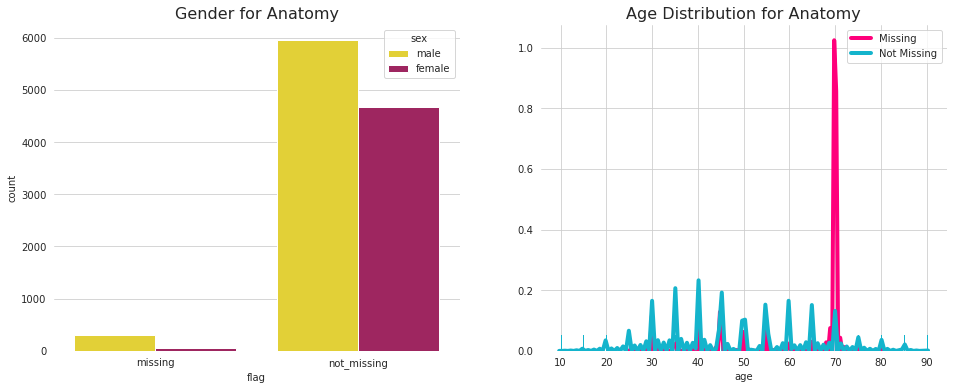

In [16]:
anatomy = test_df.copy()
anatomy['flag'] = np.where(test_df['anatomy'].isna()==True, 'missing', 'not_missing')

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax1, palette=colors_nude)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age'],
             hist=False, rug=True, label='Missing', ax=ax2, 
             color=colors_nude[2], kde_kws=dict(linewidth=4, bw=0.1))

sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age'], 
             hist=False, rug=True, label='Not Missing', ax=ax2, 
             color=colors_nude[3], kde_kws=dict(linewidth=4, bw=0.1))

ax1.set_title('Gender for Anatomy', fontsize=16)
ax2.set_title('Age Distribution for Anatomy', fontsize=16)
sns.despine(left=True, bottom=True);

# Anatomy and Diagnosis

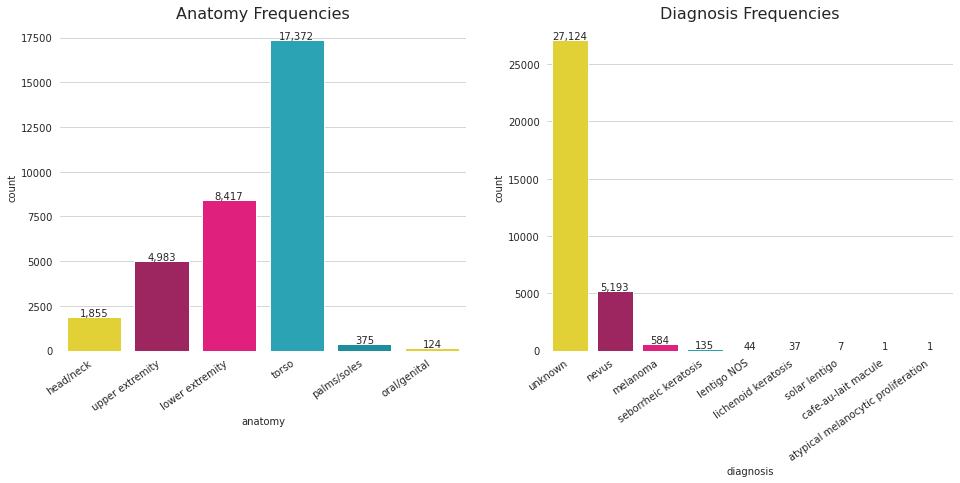

In [17]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(train_df['anatomy'], ax=ax1, palette = colors_nude)
b = sns.countplot(train_df['diagnosis'], ax=ax2, palette = colors_nude)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
ax1.set_title('Anatomy Frequencies', fontsize=16)
ax2.set_title('Diagnosis Frequencies', fontsize=16)
sns.despine(left=True, bottom=True);

# Unique Patients

In [18]:
print(
    f'Number of unique Patient ID\'s in train set: {train_df.nunique()}, Total: {train_df.count()}\nNumber of unique Patient ID\'s in test set: {test_df.nunique()}, Total: {test_df.count()}'
)

Number of unique Patient ID's in train set: dcm_name            33126
ID                   2056
sex                     2
age                    18
anatomy                 6
diagnosis               9
benign_malignant        2
target                  2
dtype: int64, Total: dcm_name            33126
ID                  33126
sex                 33061
age                 33058
anatomy             33126
diagnosis           33126
benign_malignant    33126
target              33126
dtype: int64
Number of unique Patient ID's in test set: dcm_name    10982
ID            690
sex             2
age            17
anatomy         6
dtype: int64, Total: dcm_name    10982
ID          10982
sex         10982
age         10982
anatomy     10631
dtype: int64


# Sanity Check

In [19]:
print('Train .dcm number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/train'))), '\n' +
      'Test .dcm number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/test'))), '\n' +
      'Train .jpeg number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/jpeg/train'))), '\n' +
      'Test .jpeg number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/jpeg/test'))), '\n' +
      '-----------------------', '\n' +
      'There is the same number of images as in train/ test .csv datasets')

Train .dcm number of images: 33126 
Test .dcm number of images: 10982 
Train .jpeg number of images: 33126 
Test .jpeg number of images: 10982 
----------------------- 
There is the same number of images as in train/ test .csv datasets


In [20]:
# Add Image Path

# === DICOM ===
# Create the paths
path_train = directory + '/train/' + train_df['dcm_name'] + '.dcm'
path_test = directory + '/test/' + test_df['dcm_name'] + '.dcm'

# Append to the original dataframes
train_df['path_dicom'] = path_train
test_df['path_dicom'] = path_test

# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['dcm_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test


In [21]:
# Save the files
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

In [22]:
# === DICOM ===
# Create the paths
path_train = directory + '/train/' + train_df['dcm_name'] + '.dcm'
path_test = directory + '/test/' + test_df['dcm_name'] + '.dcm'

# Append to the original dataframes
train_df['path_dicom'] = path_train
test_df['path_dicom'] = path_test

# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['dcm_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

In [23]:
def show_images(data, n = 5, rows=1, cols=5, title='Default'):
    plt.figure(figsize=(16,4))

    for k, path in enumerate(data['path_dicom'][:n]):
        image = pydicom.read_file(path)
        image = image.pixel_array
        
        # image = resize(image, (200, 200), anti_aliasing=True)

        plt.suptitle(title, fontsize = 16)
        plt.subplot(rows, cols, k+1)
        plt.imshow(image)
        plt.axis('off')

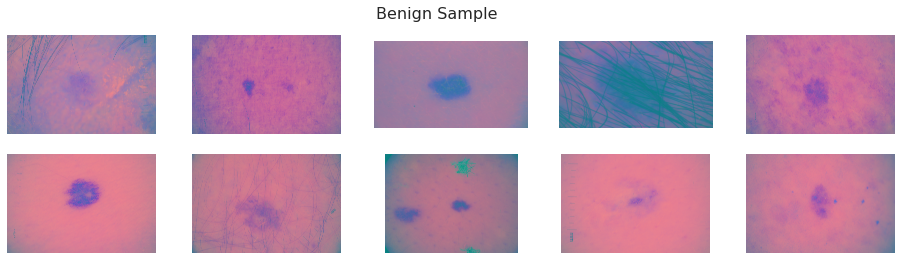

In [24]:
# Show Benign Samples
show_images(train_df[train_df['target'] == 0], n=10, rows=2, cols=5, title='Benign Sample')

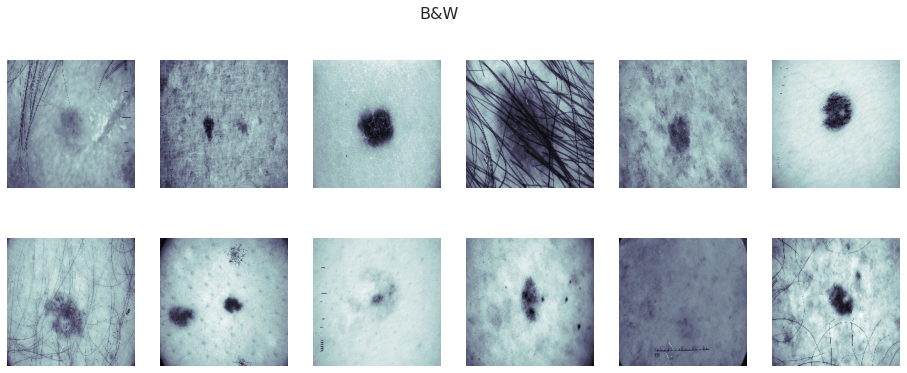

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("B&W", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

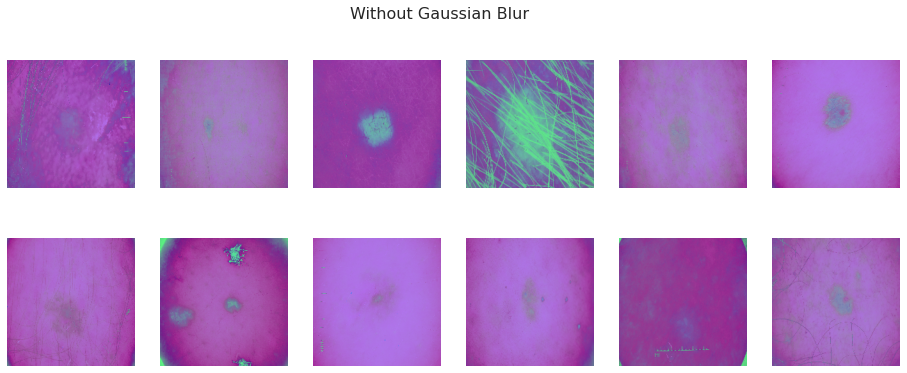

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Without Gaussian Blur", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

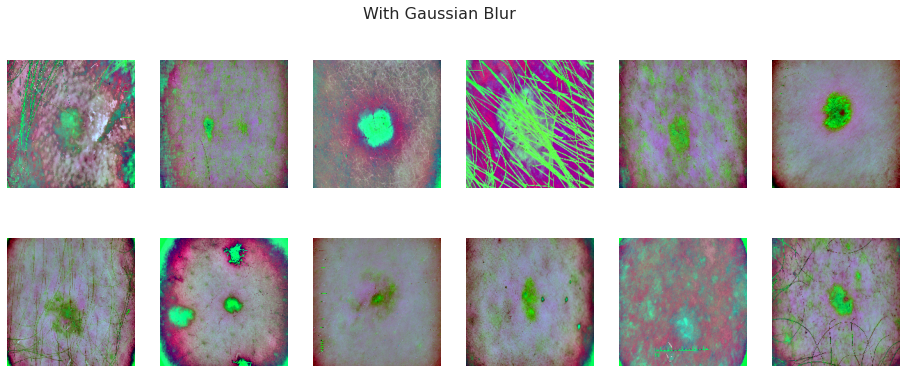

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("With Gaussian Blur", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    image=cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0) ,256/10), -4, 128)
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

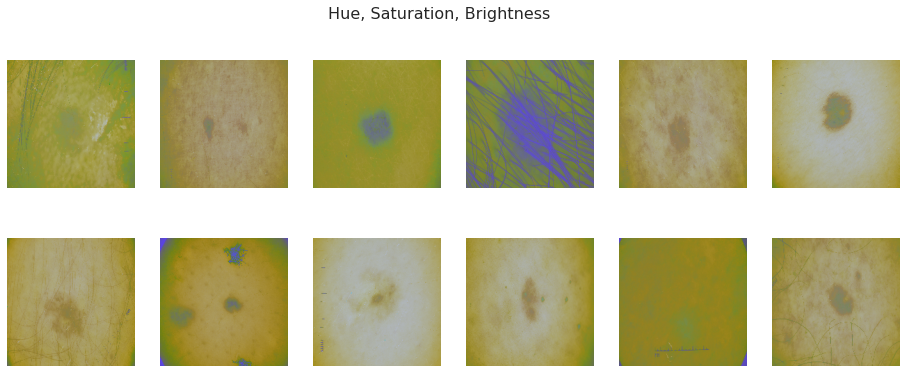

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Hue, Saturation, Brightness", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

# Torchvision.transforms

In [29]:
# Necessary Imports
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision

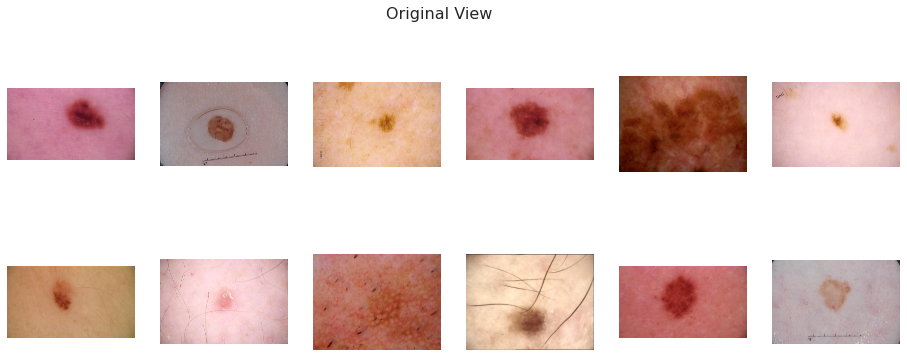

In [30]:
# Select a small sample of the .jpeg image paths
image_list = train_df.sample(12)['path_jpeg']
image_list = image_list.reset_index()['path_jpeg']

# Show the sample
plt.figure(figsize=(16,6))
plt.suptitle("Original View", fontsize = 16)
    
for k, path in enumerate(image_list):
    image = mpimg.imread(path)
        
    plt.subplot(2, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

# Post-Processing Technique

This work was adapted from the 1st place solution of the Jigsaw 2020 competition: https://www.kaggle.com/rafiko1/1st-place-jigsaw-post-processing-example

In [31]:
WEIGHT = 1

In [32]:
submission = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
sub_best = pd.read_csv('../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled.csv')

In [33]:
files_sub = [
    '../input/minmax-ensemble-0-9526-lb/submission.csv',
    '../input/new-basline-np-log2-ensemble-top-10/submission.csv',
    '../input/stacking-ensemble-on-my-submissions/submission_mean.csv',
    '../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled.csv',
    '../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled.csv',
    '../input/submission-exploration/submission.csv',
    '../input/siim-isic-melanoma-classification-ensemble/submission.csv',
    '../input/stacking-ensemble-on-my-submissions/submission_median.csv',
    '../input/analysis-of-melanoma-metadata-and-effnet-ensemble/blended_effnets.csv'
]
files_sub = sorted(files_sub)
print(len(files_sub))
files_sub

9


['../input/analysis-of-melanoma-metadata-and-effnet-ensemble/blended_effnets.csv',
 '../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled.csv',
 '../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled.csv',
 '../input/minmax-ensemble-0-9526-lb/submission.csv',
 '../input/new-basline-np-log2-ensemble-top-10/submission.csv',
 '../input/siim-isic-melanoma-classification-ensemble/submission.csv',
 '../input/stacking-ensemble-on-my-submissions/submission_mean.csv',
 '../input/stacking-ensemble-on-my-submissions/submission_median.csv',
 '../input/submission-exploration/submission.csv']

In [34]:
for file in files_sub:
    test[file.replace(".csv", "")] = pd.read_csv(file).sort_values('image_name')["target"]
test['id'] = test.index

In [35]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,../input/analysis-of-melanoma-metadata-and-effnet-ensemble/blended_effnets,../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled,../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled,../input/minmax-ensemble-0-9526-lb/submission,../input/new-basline-np-log2-ensemble-top-10/submission,../input/siim-isic-melanoma-classification-ensemble/submission,../input/stacking-ensemble-on-my-submissions/submission_mean,../input/stacking-ensemble-on-my-submissions/submission_median,../input/submission-exploration/submission,id
0,ISIC_0052060,IP_3579794,male,70.0,NaN,0.027242,0.027438,0.035168,0.000153,0.000021,0.442216,0.022257,0.022257,0.022904,0
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.027575,0.026074,0.026585,0.000118,0.000013,0.198324,0.016384,0.016384,0.018993,1
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.027162,0.025925,0.028502,0.002049,0.000281,0.164583,0.023354,0.023354,0.018233,2
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.028097,0.026442,0.030733,0.000135,0.000015,0.111062,0.017497,0.017497,0.016989,3
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.036457,0.033966,0.032410,0.000448,0.000044,0.519997,0.018092,0.018092,0.022621,4


In [36]:
test.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge',
       '../input/analysis-of-melanoma-metadata-and-effnet-ensemble/blended_effnets',
       '../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled',
       '../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled',
       '../input/minmax-ensemble-0-9526-lb/submission',
       '../input/new-basline-np-log2-ensemble-top-10/submission',
       '../input/siim-isic-melanoma-classification-ensemble/submission',
       '../input/stacking-ensemble-on-my-submissions/submission_mean',
       '../input/stacking-ensemble-on-my-submissions/submission_median',
       '../input/submission-exploration/submission', 'id'],
      dtype='object')

In [37]:
test["diff_good1"] =  test['../input/new-basline-np-log2-ensemble-top-10/submission'] - test['../input/stacking-ensemble-on-my-submissions/submission_mean']
test["diff_good1"] =  test['../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled'] - test['../input/siim-isic-melanoma-classification-ensemble/submission']
test["diff_good2"] = test['../input/analysis-of-melanoma-metadata-and-effnet-ensemble/blended_effnets'] - test['../input/stacking-ensemble-on-my-submissions/submission_median']

test["diff_bad1"] = test['../input/minmax-ensemble-0-9526-lb/submission'] - test['../input/submission-exploration/submission']

In [38]:
test["sub_best"] = test['../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled']
col_comment = ["id", "image_name", "patient_id", "sub_best"]
col_diff = [column for column in test.columns if "diff" in column]
test_diff = test[col_comment + col_diff].reset_index(drop=True)

test_diff["diff_avg"] = test_diff[col_diff].mean(axis=1) # the mean trend

In [39]:
# Apply the post-processing technique in one line (as explained in the pseudo-code of my post.
test_diff["sub_new"] = test_diff.apply(lambda x: (1+WEIGHT*x["diff_avg"])*x["sub_best"] if x["diff_avg"]<0 else (1-WEIGHT*x["diff_avg"])*x["sub_best"] + WEIGHT*x["diff_avg"] , axis=1)

In [40]:
submission["target"] = sub_best["target"]
submission.head()

,image_name,target
0,ISIC_0052060,0.035168
1,ISIC_0052349,0.026585
2,ISIC_0058510,0.028502
3,ISIC_0073313,0.030733
4,ISIC_0073502,0.032410


In [41]:
test_diff.head()

,id,image_name,patient_id,sub_best,diff_good1,diff_good2,diff_bad1,diff_avg,sub_new
0,0,ISIC_0052060,IP_3579794,0.027438,-0.407048,0.004985,-0.022751,-0.141605,0.023553
1,1,ISIC_0052349,IP_7782715,0.026074,-0.171739,0.011191,-0.018875,-0.059808,0.024515
2,2,ISIC_0058510,IP_7960270,0.025925,-0.136081,0.003808,-0.016184,-0.049486,0.024642
3,3,ISIC_0073313,IP_6375035,0.026442,-0.080329,0.010600,-0.016854,-0.028861,0.025679
4,4,ISIC_0073502,IP_0589375,0.033966,-0.487586,0.018365,-0.022173,-0.163798,0.028402


In [42]:
submission.loc[test["id"], "target"] = test_diff["sub_new"].values

In [43]:
submission.to_csv("submission.csv", index=False)
submission.head()

,image_name,target
0,ISIC_0052060,0.023553
1,ISIC_0052349,0.024515
2,ISIC_0058510,0.024642
3,ISIC_0073313,0.025679
4,ISIC_0073502,0.028402


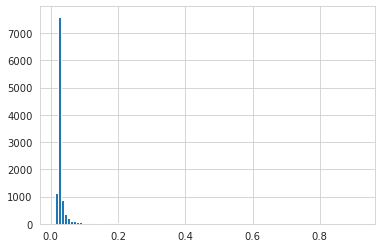

In [44]:
plt.hist(submission.target,bins=100)
plt.show()